# XGBoost Pipeline

This notebook is used for binary classification tasks using the XGBoost algorithm on a tabular dataset.
It reads the dataset from a CSV file, preprocesses the data, splits it into training and testing sets,
trains an XGBoost model, makes predictions on the test set, and evaluates the model's performance using
various metrics. Additionally, it supports plotting the final decision tree.

In [ ]:
import seaborn as sns
from scipy.stats import uniform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import xgboost as xgb
#from graphviz import Source
from xgboost import plot_tree
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, RobustScaler
#from sklearn.neighbors import LocalOutlierFactor
#from google.colab import drive
#from sklearn.manifold import TSNE
#import lime

#drive.mount('/content/drive')

warnings.filterwarnings("ignore")

In [92]:
def preprocess_data(path, embedding=False):
  """
  Reads the dataset from a CSV file, encodes categorical features, and splits the data into features and target.
  Args:
      path (str): The file path of the CSV dataset.

  Returns:
      X (pd.DataFrame): The features of the dataset.
      y (pd.Series): The target variable of the dataset.
  """
  df = pd.read_csv(path, index_col=0)

  def convert_to_int(value):
      if isinstance(value, str):
          # Extract integer from string representation
          return int(value.strip('[]'))
      else:
          return value
  # Some datasets have HOME_W as "[1]" or "[0]" instead of just 1 or 0
  df['HOME_W'] = df['HOME_W'].apply(convert_to_int)

  X, y = df.drop(["HOME_W"], axis=1), df[["HOME_W"]]

  # With emebeddings, no preprocessing is needed.
  if not embedding:
    # Encode categorical features in X
    cats = X.select_dtypes(exclude=np.number).columns.tolist()
    for col in cats:
        X[col] = OrdinalEncoder().fit_transform(X[[col]])

    # Preprocess numerical features (scaling or normalization, if needed)
    numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    scaler = RobustScaler()
    
    # Preprocess categorical features (names of people and teams)
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    label_encoder = LabelEncoder()
    for col in categorical_cols:
        X[col] = label_encoder.fit_transform(X[col])

    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

  return X, y


def train_val_test_split_data(X, y, manual_split=False):
  """
  Splits the data into training validation and testing sets.

  Args:
      X (pd.DataFrame): The features of the dataset.
      y (pd.Series): The target variable of the dataset.

  Returns:
      X_train, X_val, X_test, y_train, y_val, y_test: The training validation and testing data.
  """
  train_percent = 0.80
  validation_percent = 0.10
  test_percent = 0.10

  # Manually split so that test data is end of season 2023
  if manual_split:
    # Calculate the index for the 70% split
    train_split_index = int(len(X) * train_percent)
    val_split_index = int(len(X) * (train_percent + validation_percent))

    # Split the training and testing data into features and target
    X_train = X.iloc[:train_split_index]
    y_train = y.iloc[:train_split_index]
    X_val = X.iloc[train_split_index:val_split_index]
    y_val = y.iloc[train_split_index:val_split_index]
    X_test = X.iloc[val_split_index:]
    y_test = y.iloc[val_split_index:]
  else:
    # X_train is now 80% of the entire data set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_percent)
    # X_test and X_val are now 10% of the dataset each
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_percent/(test_percent + validation_percent))
  return X_train, X_val, X_test, y_train, y_val, y_test


def plot_decision_tree(model):
  """
  Plots a decision tree of the trained XGBoost model.

  Args:
      model (xgb.Booster): The trained XGBoost model.
  """
  plot_tree(model, num_trees=model.best_iteration)
  image = xgb.to_graphviz(model)
  image.graph_attr = {'dpi': '400'}
  image.render('xgbtree', format='png')
  source = Source(image, format='png')
  source.render("decision_tree.png", view=False)


def plot_important_features(model, top_n=20):
  """
  Plots the importance of top N features provided.

  Args:
    model (xgb.Booster): The trained XGBoost model.
    top_n (int): Number of top features to plot.
  """
  xgb.plot_importance(model, max_num_features=top_n)
  plt.yticks(fontsize='small')  # Adjust font size of Y-axis labels
  plt.tight_layout()  # Adjust layout to avoid clipping labels
  plt.savefig("/home/heminway.r/top_features.png", dpi=300, bbox_inches='tight')  # Save the figure as a PNG
  plt.show()
  plt.close()  # Close the plot to free up resources


def display_confusion_cases(model, path, embedding=False, manual_split=False, top_features=None):
  """
  Calculate confusion matrix for a trained model and display test case predictions. Helpful
  for analyzing FP/FN cases.
  """
  X, y = preprocess_data(path, embedding)
  X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split_data(X, y, manual_split)
  feature_names = list(X.columns.values)
    
  if top_features:
      # Create a new training set with only the top most important features
      X_train = X_train[top_features]
      X_val = X_val[top_features]
      X_test = X_test[top_features]
    
  # Make predictions on the test set
  y_pred = model.predict(X_test)

  # Calculate the confusion matrix
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

  print("y_test: ", y_test.shape)
  print("y_pred: ", y_pred.shape)

  # Print the confusion matrix
  print(f"True Negatives: {tn}")
  print(f"False Positives: {fp}")
  print(f"False Negatives: {fn}")
  print(f"True Positives: {tp}")

  # Create a DataFrame with the actual labels, predictions, and probabilities
  results = pd.DataFrame({
      'original_index': X_test.index,  # Include the original index
      'actual': y_test.values.ravel(),
      'predicted': y_pred
  }, columns=['original_index', 'actual', 'predicted'])

  # Add labels for TP, FP, FN, and TN
  results['result'] = ['TN' if (actual == 0 and predicted == 0) else
                     'FP' if (actual == 0 and predicted == 1) else
                     'FN' if (actual == 1 and predicted == 0) else
                     'TP' for actual, predicted in zip(results['actual'], results['predicted'])]

  # Investigate specific cases
  for case, group in results.groupby('result'):
      print(f"\n{case} cases:")
      sample_rows = group.sample(4)
      display(sample_rows[['original_index', 'actual', 'predicted']])  # Display 5 random cases
        
      # Display feature values for the sampled rows
      for idx in sample_rows['original_index']:
          print(f"\nFeature values for index {idx}:")
          print(X_test.loc[idx])
    
  # Create a DataFrame with the confusion matrix
  cm_df = pd.DataFrame({
      'Predicted HOME LOSS': [tn, fp],
      'Predicted HOME WIN': [fn, tp]
  }, index=['Actual Negative', 'Actual Positive'])

  # Plot the confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Label')
  plt.ylabel('Actual Label')

  # Save the plot as a PNG file
  plt.savefig('/home/heminway.r/confusion_matrix.png', dpi=300, bbox_inches='tight')
    
    

In [51]:
path = '/content/drive/MyDrive/betOnMeTabularDataset_L1.csv'
X, y = preprocess_data(path)

columns = X.columns.tolist()

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
yhat = lof.fit_predict(X)
outlier_indices = np.where(yhat == -1)[0]
print("Outlier indices: ", outlier_indices)
print("Num outliers: ", len(outlier_indices))

# Compare using original feature values
df = pd.read_csv(path, index_col=0)
X_raw, y_raw = df.drop(["HOME_W"], axis=1), df[["HOME_W"]]

for column in columns:
    plt.figure(figsize=(6, 4))
    plt.scatter(X_raw.index, X_raw[column], c=yhat)
    plt.title(f"Local Outlier Factor for {column}")
    plt.xlabel(f"Sample ID")
    plt.ylabel(f"{column} Value")
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/betOnMeTabularDataset_L1.csv'

In [ ]:
def display_scores(scores):
  """
  Helper method to print model scores.
  """
  print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))


def report_best_scores(results, n_top=3):
  """
  Helper method for printing the top N scores from a list of results.
  """
  for i in range(1, n_top + 1):
      candidates = np.flatnonzero(results['rank_test_score'] == i)
      for candidate in candidates:
          print("Model with rank: {0}".format(i))
          print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                results['mean_test_score'][candidate],
                results['std_test_score'][candidate]))
          print("Parameters: {0}".format(results['params'][candidate]))
          print("")


def find_best_xgb_model(X_train, y_train, X_val, y_val, X_test, y_test, feature_names, param_grid, output_file=None):
  """
  Run a randomized grid search with cross-validation to find the best parameter values for XGBoost, given
  a dataset and parameter grid to search within.
  """
  # Create a validation set
  eval_set = [(X_val, y_val)] #, (X_train, y_train)]
  # Add 'eval_metric' parameter to track performance on the validation set
  fit_params = {'eval_set': eval_set, 'eval_metric': ['auc', 'logloss'], 'early_stopping_rounds': 20}

  print("Running parameter search... ")
  xgb_model = xgb.XGBClassifier(objective='binary:logistic')
  random_search = RandomizedSearchCV(xgb_model, param_grid, n_iter=1, cv=5, scoring='balanced_accuracy',
                                     verbose=3, n_jobs=-1, random_state=42, return_train_score=True)
  random_search.fit(X_train, y_train, **fit_params)

  # Test the optimized model
  model = random_search.best_estimator_
  preds = model.predict(X_test)
  preds[preds >= 0.5] = 1
  preds[preds < 0.5] = 0

  # Print top 5 model parameter sets
  report_best_scores(random_search.cv_results_, 5)

  model_metrics = f"Best Parameters: {random_search.best_params_}\n"
  model_metrics += f"(Best Model) TEST Accuracy: {accuracy_score(y_test, preds)}\n"
  model_metrics += f"(Best Model) TEST F1: {f1_score(y_test, preds)}\n"
  model_metrics += f"(Best Model) TEST Precision: {precision_score(y_test, preds)}"
  model_metrics += f"(Best Model) TEST Recall: {recall_score(y_test, preds)}"

  preds = model.predict(X_val)
  preds[preds >= 0.5] = 1
  preds[preds < 0.5] = 0

  model_metrics += f"(Best Model) VAL Accuracy: {accuracy_score(y_val, preds)}\n"
  model_metrics += f"(Best Model) VAL F1: {f1_score(y_val, preds)}\n"
  model_metrics += f"(Best Model) VAL Precision: {precision_score(y_val, preds)}\n"
  model_metrics += f"(Best Model) VAL Recall: {recall_score(y_val, preds)}\n"

  preds = model.predict(X_train)
  preds[preds >= 0.5] = 1
  preds[preds < 0.5] = 0

  model_metrics += f"(Best Model) TRAIN Accuracy: {accuracy_score(y_train, preds)}\n"
  model_metrics += f"(Best Model) TRAIN F1: {f1_score(y_train, preds)}\n"
  model_metrics += f"(Best Model) TRAIN Precision: {precision_score(y_train, preds)}\n"
  model_metrics += f"(Best Model) TRAIN Recall: {recall_score(y_train, preds)}\n"
  print(model_metrics)
  if output_file != None:
    # Write model metrics to the text file
    with open(output_file, 'w') as file:
      file.write(model_metrics)

  return model

def run_parameter_search(path, param_grid, output_file=None, manual_split=False, embedding=False, top_features=None):
  """
  Run a randomized hyperparameter search on XGBoost to find optimal parameters.

  Reference: https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn
  """
  X, y = preprocess_data(path, embedding)
  X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split_data(X, y, manual_split)
  feature_names = list(X.columns.values)
    
  if top_features:
    # Create a new training set with only the top most important features
    X_train = X_train[top_features]
    X_val = X_val[top_features]
    X_test = X_test[top_features]
  model = find_best_xgb_model(X_train, y_train, X_val, y_val, X_test, y_test, feature_names, param_grid)
  return model

In [ ]:
path = '/content/drive/MyDrive/betOnMeTabularDataset_L3.csv'

X, y = preprocess_data(path)

# Fit the t-SNE model and transform the data
tsne_model = TSNE(n_components=3, random_state=42)
X_tsne = tsne_model.fit_transform(X)

# Create a DataFrame with the t-SNE components and labels
tsne_data = pd.DataFrame(data=X_tsne, columns=['tsne_1', 'tsne_2', 'tsne_3'])
tsne_data['label'] = y

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
for label, data in tsne_data.groupby('label'):
    ax.scatter(data['tsne_1'], data['tsne_2'], data['tsne_3'], label=label, alpha=0.7)

# Set labels and title
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.set_title('3D t-SNE Projection of the Dataset', fontsize=16)

# Add a legend
ax.legend()

# Show the plot
plt.show()

## Parameter Optimization via Randomized Search

#### Basketball Features

In [ ]:
# RUN A HYPER PARAMETER SEARCH TO FIND BEST PARAMS FOR XGBOOST AND DATASET
param_grid = {
    'min_child_weight': [1, 3, 5, 7, 9],  # Minimum sum of instance weights needed in a child
    'reg_alpha': [0, 0.5, 1],  # L1 regularization term on weights
    "reg_lambda": [0, 0.5, 1],  # L2 regularization term on weights
    "colsample_bytree": [0.8, 0.9, 1.0],
    "learning_rate": [0.01, 0.05, 0.1], # default 0.1
    "max_depth": [2, 3, 5, 7, 9], # default 3
    "n_estimators": [10000], # Using high `n_estimators` since we have early stopping enabled
    "subsample": [0.8, 0.9, 1.0]
}

In [ ]:
#path = '/content/drive/MyDrive/betOnMeTabularDataset_L0.csv'
path = 'betOnMeTabularDataset_L0.csv'

param_grid = {'subsample': [0.8], 'reg_lambda': [0.5], 'reg_alpha': [1], 'n_estimators': [10000], 'min_child_weight': [3], 'max_depth': [1], 'learning_rate': [0.1], 'colsample_bytree': [0.9]}
model = run_parameter_search(path, param_grid, output_file="/home/heminway.r/results_man_tab_L0.txt", manual_split=True)
print("---------------------------------------------------------------------------------------------------------------")
param_grid = {'subsample': [1.0], 'reg_lambda': [1], 'reg_alpha': [1], 'n_estimators': [10000], 'min_child_weight': [7], 'max_depth': [2], 'learning_rate': [0.1], 'colsample_bytree': [0.9]}
model = run_parameter_search(path, param_grid, output_file="/home/heminway.r/results_auto_tab_L0.txt", manual_split=False)

In [ ]:
plot_decision_tree(model)

In [ ]:
plot_important_features(model, top_n=25)

In [32]:
path = '/content/drive/MyDrive/betOnMeTabularDataset_L1.csv'
path = 'betOnMeTabularDataset_L1.csv'

param_grid = {'subsample': [1.0], 'reg_lambda': [0], 'reg_alpha': [0], 'n_estimators': [10000], 'min_child_weight': [7], 'max_depth': [2], 'learning_rate': [0.1], 'colsample_bytree': [0.9]}
#model = run_parameter_search(path, param_grid, output_file="/home/heminway.r/results_man_tab_L1.txt", manual_split=True)
print("---------------------------------------------------------------------------------------------------------------")

param_grid = {'subsample': [1.0], 'reg_lambda': [0.5], 'reg_alpha': [0], 'n_estimators': [10000], 'min_child_weight': [3], 'max_depth': [2], 'learning_rate': [0.1], 'colsample_bytree': [0.9]}
model = run_parameter_search(path, param_grid, output_file="/home/heminway.r/results_auto_tab_L1.txt", manual_split=False)

---------------------------------------------------------------------------------------------------------------
Running parameter search... 
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[0]	validation_0-auc:0.71915	validation_0-logloss:0.66478
[1]	validation_0-auc:0.72114	validation_0-logloss:0.65355
[2]	validation_0-auc:0.71444	validation_0-logloss:0.64500
[3]	validation_0-auc:0.72251	validation_0-logloss:0.63742
[4]	validation_0-auc:0.73132	validation_0-logloss:0.62992
[5]	validation_0-auc:0.74062	validation_0-logloss:0.62227
[6]	validation_0-auc:0.73737	validation_0-logloss:0.61840
[7]	validation_0-auc:0.73940	validation_0-logloss:0.61380
[8]	validation_0-auc:0.74142	validation_0-logloss:0.60896
[9]	validation_0-auc:0.74350	validation_0-logloss:0.60487
[10]	validation_0-auc:0.74471	validation_0-logloss:0.60082
[11]	validation_0-auc:0.74703	validation_0-logloss:0.59750
[12]	validation_0-auc:0.74920	validation_0-logloss:0.59451
[13]	validation_0-auc:0.75091	validation_0-

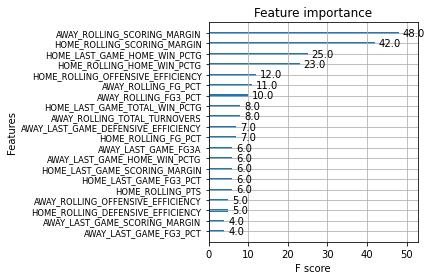

In [33]:
plot_important_features(model, top_n=20)

In [ ]:
path = '/content/drive/MyDrive/betOnMeTabularDataset_L2.csv'
path = 'betOnMeTabularDataset_L2.csv'

param_grid = {'subsample': [0.9], 'reg_lambda': [0], 'reg_alpha': [0.5], 'n_estimators': [10000], 'min_child_weight': [3], 'max_depth': [2], 'learning_rate': [0.05], 'colsample_bytree': [0.8]}
model = run_parameter_search(path, param_grid, output_file="/home/heminway.r/results_man_tab_L2.txt", manual_split=True)
print("---------------------------------------------------------------------------------------------------------------")

param_grid = {'subsample': [1.0], 'reg_lambda': [0.5], 'reg_alpha': [0], 'n_estimators': [10000], 'min_child_weight': [1], 'max_depth': [2], 'learning_rate': [0.05], 'colsample_bytree': [1]}
model = run_parameter_search(path, param_grid, output_file="/home/heminway.r/results_auto_tab_L2.txt", manual_split=False)

In [75]:
path = '/content/drive/MyDrive/betOnMeTabularDataset_L3.csv'
path = 'betOnMeTabularDataset_L3.csv'

# Optimal values found via previous parameter search
param_grid = {'subsample': [0.8], 'reg_lambda': [1], 'reg_alpha':[1], 'n_estimators': [10000], 'min_child_weight': [1], 'max_depth': [2], 'learning_rate': [0.1], 'colsample_bytree': [0.8]}
#model = run_parameter_search(path, param_grid, output_file="/home/heminway.r/results_man_tab_L3.txt", manual_split=True)
print("---------------------------------------------------------------------------------------------------------------")

param_grid = {'subsample': [0.8], 'reg_lambda': [1], 'reg_alpha':[1], 'n_estimators': [10000], 'min_child_weight': [1], 'max_depth': [2], 'learning_rate': [0.1], 'colsample_bytree': [0.8]}
model = run_parameter_search(path, param_grid, output_file="/home/heminway.r/results_auto_tab_L3.txt", manual_split=False)

---------------------------------------------------------------------------------------------------------------
Running parameter search... 
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[0]	validation_0-auc:0.72676	validation_0-logloss:0.66718
[1]	validation_0-auc:0.73465	validation_0-logloss:0.65473
[2]	validation_0-auc:0.75106	validation_0-logloss:0.64620
[3]	validation_0-auc:0.75061	validation_0-logloss:0.63728
[4]	validation_0-auc:0.75483	validation_0-logloss:0.62878
[5]	validation_0-auc:0.76043	validation_0-logloss:0.62345
[6]	validation_0-auc:0.76342	validation_0-logloss:0.61825
[7]	validation_0-auc:0.76747	validation_0-logloss:0.61114
[8]	validation_0-auc:0.76417	validation_0-logloss:0.60977
[9]	validation_0-auc:0.76441	validation_0-logloss:0.60602
[10]	validation_0-auc:0.76843	validation_0-logloss:0.60156
[11]	validation_0-auc:0.77032	validation_0-logloss:0.59648
[12]	validation_0-auc:0.77608	validation_0-logloss:0.59134
[13]	validation_0-auc:0.77738	validation_0-

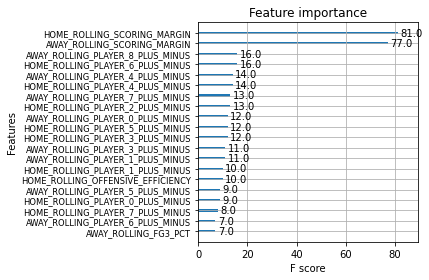

In [31]:
plot_important_features(model, top_n=20)

In [76]:
# Get feature importances from the best model
importances = model.feature_importances_
N=50
# Get the indices of the top N most important features
top_indices = np.argsort(importances)[::-1][:N]

path = 'betOnMeTabularDataset_L3.csv'
X, _ = preprocess_data(path)
# Get the names of the top N most important features
top_features = [X.columns[i] for i in top_indices]
print("Top features: ", top_features)

#model = run_parameter_search(path, param_grid, output_file="/home/heminway.r/results_man_tab_pca_L3.txt", manual_split=True, top_features=top_features)
print("---------------------------------------------------------------------------------------------------------------")
model = run_parameter_search(path, param_grid, output_file="/home/heminway.r/results_auto_tab_pca_L3.txt", manual_split=False, top_features=top_features)

Top features:  ['HOME_ROLLING_SCORING_MARGIN', 'HOME_ROLLING_REB_DIFFERENTIAL', 'HOME_LAST_GAME_TOTAL_WIN_PCTG', 'AWAY_ROLLING_SCORING_MARGIN', 'HOME_ROLLING_OFFENSIVE_EFFICIENCY', 'HOME_LAST_GAME_SCORING_MARGIN', 'HOME_ROLLING_TOTAL_WIN_PCTG', 'HOME_LAST_GAME_HOME_WIN_PCTG', 'HOME_ROLLING_PLAYER_0_FG3_PCT', 'HOME_ROLLING_PLAYER_4_PLUS_MINUS', 'HOME_ROLLING_PLAYER_0_PLUS_MINUS', 'AWAY_ROLLING_PLAYER_0_PLUS_MINUS', 'AWAY_ROLLING_PLAYER_3_PLUS_MINUS', 'AWAY_ROLLING_PLAYER_9_PTS', 'AWAY_ROLLING_PLAYER_2_PTS', 'HOME_ROLLING_PLAYER_1_AST', 'HOME_ROLLING_FG3_PCT', 'AWAY_ROLLING_PLAYER_1_PLUS_MINUS', 'AWAY_ROLLING_FG3_PCT', 'AWAY_ROLLING_PTS', 'HOME_ROLLING_PLAYER_5_PLUS_MINUS', 'AWAY_ROLLING_OFFENSIVE_EFFICIENCY', 'HOME_ROLLING_PTS', 'AWAY_ROLLING_PLAYER_8_FG3_PCT', 'AWAY_ROLLING_PLAYER_0_PTS', 'HOME_ROLLING_PLAYER_9_REB', 'AWAY_ROLLING_PLAYER_5_PLUS_MINUS', 'HOME_LAST_GAME_FG3_PCT', 'AWAY_ROLLING_PLAYER_1_PTS', 'HOME_ROLLING_PLAYER_8_FG3_PCT', 'HOME_NICKNAME', 'HOME_LAST_GAME_FG_PCT', 'HOME

y_test:  (343, 1)
y_pred:  (343,)
True Negatives: 113
False Positives: 46
False Negatives: 19
True Positives: 165

FN cases:


,original_index,actual,predicted
198,747,1,0
37,1964,1,0
23,2445,1,0
280,3400,1,0



Feature values for index 747:
HOME_ROLLING_SCORING_MARGIN         -0.698164
HOME_ROLLING_REB_DIFFERENTIAL        0.100000
HOME_LAST_GAME_TOTAL_WIN_PCTG       -1.157895
AWAY_ROLLING_SCORING_MARGIN          0.826905
HOME_ROLLING_OFFENSIVE_EFFICIENCY   -0.142857
HOME_LAST_GAME_SCORING_MARGIN        0.210526
HOME_ROLLING_TOTAL_WIN_PCTG         -1.200000
HOME_LAST_GAME_HOME_WIN_PCTG        -0.956522
HOME_ROLLING_PLAYER_0_FG3_PCT        0.125000
HOME_ROLLING_PLAYER_4_PLUS_MINUS    -0.949153
HOME_ROLLING_PLAYER_0_PLUS_MINUS    -0.016949
AWAY_ROLLING_PLAYER_0_PLUS_MINUS     0.083333
AWAY_ROLLING_PLAYER_3_PLUS_MINUS     1.385965
AWAY_ROLLING_PLAYER_9_PTS           -0.461538
AWAY_ROLLING_PLAYER_2_PTS            0.228916
HOME_ROLLING_PLAYER_1_AST           -0.421053
HOME_ROLLING_FG3_PCT                 0.250000
AWAY_ROLLING_PLAYER_1_PLUS_MINUS     0.928571
AWAY_ROLLING_FG3_PCT                 0.250000
AWAY_ROLLING_PTS                     0.102564
HOME_ROLLING_PLAYER_5_PLUS_MINUS    -1.380952
AWA

,original_index,actual,predicted
215,382,0,1
25,215,0,1
250,2297,0,1
17,66,0,1



Feature values for index 382:
HOME_ROLLING_SCORING_MARGIN          0.180560
HOME_ROLLING_REB_DIFFERENTIAL       -0.483333
HOME_LAST_GAME_TOTAL_WIN_PCTG        0.157895
AWAY_ROLLING_SCORING_MARGIN          0.111077
HOME_ROLLING_OFFENSIVE_EFFICIENCY   -0.142857
HOME_LAST_GAME_SCORING_MARGIN       -1.210526
HOME_ROLLING_TOTAL_WIN_PCTG          0.100000
HOME_LAST_GAME_HOME_WIN_PCTG        -1.000000
HOME_ROLLING_PLAYER_0_FG3_PCT       -1.687500
HOME_ROLLING_PLAYER_4_PLUS_MINUS     0.152542
HOME_ROLLING_PLAYER_0_PLUS_MINUS    -0.338983
AWAY_ROLLING_PLAYER_0_PLUS_MINUS     0.616667
AWAY_ROLLING_PLAYER_3_PLUS_MINUS     0.964912
AWAY_ROLLING_PLAYER_9_PTS           -0.461538
AWAY_ROLLING_PLAYER_2_PTS            0.000000
HOME_ROLLING_PLAYER_1_AST            0.210526
HOME_ROLLING_FG3_PCT                -0.500000
AWAY_ROLLING_PLAYER_1_PLUS_MINUS    -0.196429
AWAY_ROLLING_FG3_PCT                -0.500000
AWAY_ROLLING_PTS                    -0.205128
HOME_ROLLING_PLAYER_5_PLUS_MINUS     0.000000
AWA

,original_index,actual,predicted
240,1571,0,0
320,3185,0,0
78,408,0,0
40,2048,0,0



Feature values for index 1571:
HOME_ROLLING_SCORING_MARGIN         -1.757448
HOME_ROLLING_REB_DIFFERENTIAL       -0.483333
HOME_LAST_GAME_TOTAL_WIN_PCTG       -1.157895
AWAY_ROLLING_SCORING_MARGIN          0.074051
HOME_ROLLING_OFFENSIVE_EFFICIENCY   -0.428571
HOME_LAST_GAME_SCORING_MARGIN       -0.578947
HOME_ROLLING_TOTAL_WIN_PCTG         -1.000000
HOME_LAST_GAME_HOME_WIN_PCTG        -0.521739
HOME_ROLLING_PLAYER_0_FG3_PCT        0.750000
HOME_ROLLING_PLAYER_4_PLUS_MINUS    -0.169492
HOME_ROLLING_PLAYER_0_PLUS_MINUS    -0.627119
AWAY_ROLLING_PLAYER_0_PLUS_MINUS    -0.316667
AWAY_ROLLING_PLAYER_3_PLUS_MINUS     0.017544
AWAY_ROLLING_PLAYER_9_PTS           -0.461538
AWAY_ROLLING_PLAYER_2_PTS            1.927711
HOME_ROLLING_PLAYER_1_AST           -0.473684
HOME_ROLLING_FG3_PCT                -0.500000
AWAY_ROLLING_PLAYER_1_PLUS_MINUS    -0.089286
AWAY_ROLLING_FG3_PCT                -0.250000
AWAY_ROLLING_PTS                    -0.230769
HOME_ROLLING_PLAYER_5_PLUS_MINUS    -2.500000
AW

,original_index,actual,predicted
179,799,1,1
296,2863,1,1
225,779,1,1
218,2939,1,1



Feature values for index 799:
HOME_ROLLING_SCORING_MARGIN          1.095396
HOME_ROLLING_REB_DIFFERENTIAL        0.583333
HOME_LAST_GAME_TOTAL_WIN_PCTG        0.894737
AWAY_ROLLING_SCORING_MARGIN          0.049367
HOME_ROLLING_OFFENSIVE_EFFICIENCY    1.142857
HOME_LAST_GAME_SCORING_MARGIN        0.210526
HOME_ROLLING_TOTAL_WIN_PCTG          0.700000
HOME_LAST_GAME_HOME_WIN_PCTG         0.652174
HOME_ROLLING_PLAYER_0_FG3_PCT        1.375000
HOME_ROLLING_PLAYER_4_PLUS_MINUS     0.627119
HOME_ROLLING_PLAYER_0_PLUS_MINUS     1.220339
AWAY_ROLLING_PLAYER_0_PLUS_MINUS     0.116667
AWAY_ROLLING_PLAYER_3_PLUS_MINUS    -0.017544
AWAY_ROLLING_PLAYER_9_PTS           -0.461538
AWAY_ROLLING_PLAYER_2_PTS           -0.397590
HOME_ROLLING_PLAYER_1_AST           -0.368421
HOME_ROLLING_FG3_PCT                 0.750000
AWAY_ROLLING_PLAYER_1_PLUS_MINUS     0.267857
AWAY_ROLLING_FG3_PCT                 1.250000
AWAY_ROLLING_PTS                    -0.243590
HOME_ROLLING_PLAYER_5_PLUS_MINUS     1.952381
AWA

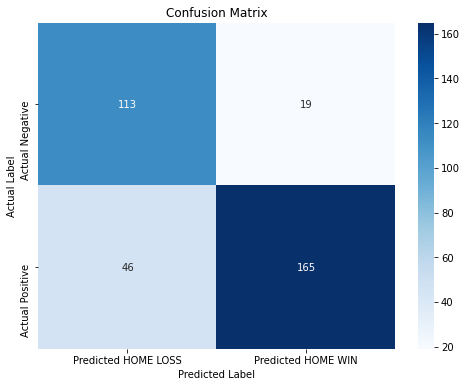

In [93]:
display_confusion_cases(model, path, embedding=False, manual_split=False, top_features=top_features)

#### Embeddings

In [ ]:
path = '/content/drive/MyDrive/llama2_embeddings_L0.csv'
path = 'mistral_embedding_L0.csv'

param_grid = {'subsample': [0.5], 'reg_lambda': [1], 'reg_alpha': [0.1], 'n_estimators': [10000], 'min_child_weight': [5], 'max_depth': [3], 'learning_rate': [0.01], 'colsample_bytree': [0.8]}
model = run_parameter_search(path, param_grid, output_file="/home/heminway.r/results_man_llm_L0.txt", manual_split=True, embedding=True)
print("---------------------------------------------------------------------------------------------------------------")
param_grid = {'subsample': [0.8], 'reg_lambda': [0.5], 'reg_alpha': [1], 'n_estimators': [10000], 'min_child_weight': [9], 'max_depth': [3], 'learning_rate': [0.01], 'colsample_bytree': [0.9]}
model = run_parameter_search(path, param_grid, output_file="/home/heminway.r/results_auto_llm_L0.txt", manual_split=False, embedding=True)

In [94]:
path = '/content/drive/MyDrive/llama2_embeddings_L1.csv'
path = 'mistral_embedding_L1.csv'

param_grid = {'subsample': [0.8], 'reg_lambda': [0.5], 'reg_alpha': [1], 'n_estimators': [10000], 'min_child_weight': [9], 'max_depth': [3], 'learning_rate': [0.01], 'colsample_bytree': [0.9]}
#model = run_parameter_search(path, param_grid, output_file="/home/heminway.r/results_man_llm_L1.txt", manual_split=True, embedding=True)
print("---------------------------------------------------------------------------------------------------------------")
param_grid = {'subsample': [0.9], 'reg_lambda': [0.1], 'reg_alpha': [0], 'n_estimators': [10000], 'min_child_weight': [1], 'max_depth': [2], 'learning_rate': [0.1], 'colsample_bytree': [0.8]}
model = run_parameter_search(path, param_grid, output_file="/home/heminway.r/results_auto_llm_L1.txt", manual_split=False, embedding=True)

---------------------------------------------------------------------------------------------------------------
Running parameter search... 
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[0]	validation_0-auc:0.61342	validation_0-logloss:0.67928
[1]	validation_0-auc:0.62139	validation_0-logloss:0.67533
[2]	validation_0-auc:0.65495	validation_0-logloss:0.66962
[3]	validation_0-auc:0.66599	validation_0-logloss:0.66502
[4]	validation_0-auc:0.67190	validation_0-logloss:0.66051
[5]	validation_0-auc:0.67400	validation_0-logloss:0.65768
[6]	validation_0-auc:0.68903	validation_0-logloss:0.65286
[7]	validation_0-auc:0.69667	validation_0-logloss:0.64921
[8]	validation_0-auc:0.69129	validation_0-logloss:0.64888
[9]	validation_0-auc:0.69413	validation_0-logloss:0.64673
[10]	validation_0-auc:0.69439	validation_0-logloss:0.64542
[11]	validation_0-auc:0.69275	validation_0-logloss:0.64403
[12]	validation_0-auc:0.69731	validation_0-logloss:0.64127
[13]	validation_0-auc:0.69724	validation_0-

y_test:  (343, 1)
y_pred:  (343,)
True Negatives: 99
False Positives: 52
False Negatives: 34
True Positives: 158

FN cases:


,original_index,actual,predicted
171,0.001290,1,0
265,0.000657,1,0
156,0.001450,1,0
314,0.001356,1,0



Feature values for index 0.0012898867717012:
1       0.020033
2      -0.024269
3      -0.034330
4       0.008483
5      -0.018483
          ...   
4091   -0.085613
4092    0.031583
4093   -0.006062
4094    0.004066
4095   -0.006970
Name: 0.0012898867717012, Length: 4095, dtype: float64

Feature values for index 0.0006572761922143:
1       0.020439
2      -0.025389
3      -0.034747
4       0.009249
5      -0.018670
          ...   
4091   -0.086202
4092    0.030661
4093   -0.004933
4094    0.005441
4095   -0.007653
Name: 0.0006572761922143, Length: 4095, dtype: float64

Feature values for index 0.0014502212870866:
1       0.019868
2      -0.024990
3      -0.034036
4       0.009111
5      -0.018460
          ...   
4091   -0.082794
4092    0.031315
4093   -0.005948
4094    0.006036
4095   -0.008071
Name: 0.0014502212870866, Length: 4095, dtype: float64

Feature values for index 0.0013559275539591:
1       0.019613
2      -0.025105
3      -0.034087
4       0.009947
5      -0.018273
     

,original_index,actual,predicted
60,-0.000030,0,1
283,0.001136,0,1
214,0.001918,0,1
201,0.001732,0,1



Feature values for index -3.0473982405965216e-05:
1       0.020726
2      -0.024431
3      -0.035753
4       0.009377
5      -0.019677
          ...   
4091   -0.090464
4092    0.029977
4093   -0.004373
4094    0.004198
4095   -0.007632
Name: -3.0473982405965216e-05, Length: 4095, dtype: float64

Feature values for index 0.0011362152872607:
1       0.020263
2      -0.024364
3      -0.035437
4       0.009870
5      -0.018342
          ...   
4091   -0.085654
4092    0.032076
4093   -0.004756
4094    0.005183
4095   -0.007424
Name: 0.0011362152872607, Length: 4095, dtype: float64

Feature values for index 0.0019178497605025:
1       0.020148
2      -0.025468
3      -0.033984
4       0.008080
5      -0.018442
          ...   
4091   -0.084104
4092    0.032484
4093   -0.005339
4094    0.004876
4095   -0.007696
Name: 0.0019178497605025, Length: 4095, dtype: float64

Feature values for index 0.0017318290192633:
1       0.019994
2      -0.023580
3      -0.035595
4       0.008907
5      -0.01

,original_index,actual,predicted
254,0.001100,0,0
104,0.001675,0,0
320,0.001768,0,0
53,0.001245,0,0



Feature values for index 0.0010995961492881:
1       0.020607
2      -0.024852
3      -0.034036
4       0.008802
5      -0.018830
          ...   
4091   -0.088981
4092    0.032150
4093   -0.006046
4094    0.005484
4095   -0.006790
Name: 0.0010995961492881, Length: 4095, dtype: float64

Feature values for index 0.0016754714306443:
1       0.020693
2      -0.023816
3      -0.033909
4       0.008923
5      -0.018200
          ...   
4091   -0.089382
4092    0.031274
4093   -0.006009
4094    0.004705
4095   -0.006943
Name: 0.0016754714306443, Length: 4095, dtype: float64

Feature values for index 0.0017681365134194:
1       0.019968
2      -0.024347
3      -0.035100
4       0.009826
5      -0.017727
          ...   
4091   -0.086597
4092    0.030542
4093   -0.004794
4094    0.005443
4095   -0.007672
Name: 0.0017681365134194, Length: 4095, dtype: float64

Feature values for index 0.0012450956273823:
1       0.020023
2      -0.025294
3      -0.033824
4       0.008982
5      -0.017866
     

,original_index,actual,predicted
143,0.001285,1,1
108,0.001913,1,1
308,0.001340,1,1
232,0.001030,1,1



Feature values for index 0.0012847502948716:
1       0.021009
2      -0.024538
3      -0.035022
4       0.008420
5      -0.018136
          ...   
4091   -0.085786
4092    0.030954
4093   -0.005753
4094    0.006010
4095   -0.008111
Name: 0.0012847502948716, Length: 4095, dtype: float64

Feature values for index 0.0019129331922158:
1       0.020128
2      -0.025718
3      -0.033886
4       0.009276
5      -0.018805
          ...   
4091   -0.084842
4092    0.032170
4093   -0.004179
4094    0.005142
4095   -0.008766
Name: 0.0019129331922158, Length: 4095, dtype: float64

Feature values for index 0.0013404648052528:
1       0.020178
2      -0.024059
3      -0.034541
4       0.008879
5      -0.018483
          ...   
4091   -0.087155
4092    0.031749
4093   -0.004366
4094    0.004888
4095   -0.008526
Name: 0.0013404648052528, Length: 4095, dtype: float64

Feature values for index 0.00102981319651:
1       0.020489
2      -0.023983
3      -0.035740
4       0.009081
5      -0.018468
       

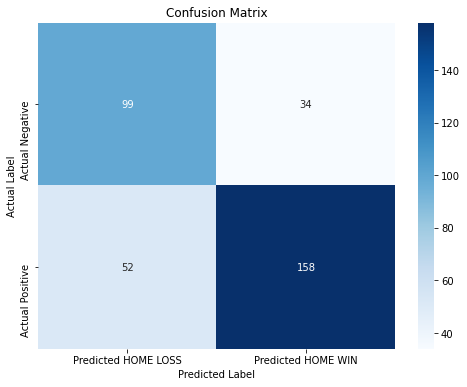

In [95]:
display_confusion_cases(model, path, embedding=True, manual_split=False, top_features=None)

In [ ]:
path = '/content/drive/MyDrive/llama2_embeddings_L2.csv'
path = 'mistral_embedding_L2.csv'

param_grid = {'subsample': [1.0], 'reg_lambda': [0.5], 'reg_alpha': [1], 'n_estimators': [10000], 'min_child_weight': [5], 'max_depth': [5], 'learning_rate': [0.05], 'colsample_bytree': [0.8]}
model = run_parameter_search(path, param_grid, output_file="/home/heminway.r/results_man_llm_L2.txt", manual_split=True, embedding=True)
print("---------------------------------------------------------------------------------------------------------------")
model = run_parameter_search(path, param_grid, output_file="/home/heminway.r/results_auto_llm_L2.txt", manual_split=False, embedding=True)

In [ ]:
#path = '/content/drive/MyDrive/llama2_embeddings_L3.csv'
path = 'mistral_embedding_L3.csv'

param_grid = {'subsample': [1.0], 'reg_lambda': [0.5], 'reg_alpha': [1], 'n_estimators': [10000], 'min_child_weight': [5], 'max_depth': [5], 'learning_rate': [0.05], 'colsample_bytree': [0.8]}
model_ = run_parameter_search(path, param_grid, output_file="/home/heminway.r/results_man_llm_L3.txt", manual_split=True, embedding=True)
print("---------------------------------------------------------------------------------------------------------------")
model_ = run_parameter_search(path, param_grid, output_file="/home/heminway.r/results_auto_llm_L3.txt", manual_split=False, embedding=True)

In [ ]:
# Get feature importances from the best model
importances = model_.feature_importances_

# Get the indices of the top 50 most important features
top_indices = np.argsort(importances)[::-1][:50]

path = 'mistral_embedding_L3.csv'
X, _ = preprocess_data(path, embedding=True)
# Get the names of the top N most important features
top_features = [X.columns[i] for i in top_indices]
print("Top features: ", top_features)

param_grid = {'subsample': [0.9], 'reg_lambda': [0.0], 'reg_alpha': [0.5], 'n_estimators': [10000], 'min_child_weight': [3], 'max_depth': [5], 'learning_rate': [0.05], 'colsample_bytree': [0.9]}
model = run_parameter_search(path, param_grid, output_file="/home/heminway.r/results_man_llm_pca_L3.txt", manual_split=True, embedding=True, top_features=top_features)
print("---------------------------------------------------------------------------------------------------------------")
model = run_parameter_search(path, param_grid, output_file="/home/heminway.r/results_man_llm_pca_L3.txt", manual_split=False, embedding=True, top_features=top_features)